#### Задание
Вам необходимо провести базовый EDA выбранного набора данных.

Требования к анализу:

- построить не менее 4 визуализаций различных видов;  
- каждая визуализация должным образом оформлена и читается даже в отрыве от контекста;  
- по каждой визуализации необходимо написать вывод (какую гипотезу на ее основе можно выдвинуть?)

Доп:
- построить дополнительно не менее 2 визуализаций (итого не менее 6);
- в работе должны присутствовать следующие визуализации: boxplot, heatmap, scatter plot matrix;

In [262]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json
from urllib.request import urlopen
from collections import Counter
from wordcloud import WordCloud

In [263]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10,8

In [264]:
#загружаем файл со статистикой по видео из вкладки"в тренде" ютуба 
df = pd.read_csv('https://raw.githubusercontent.com/Mamaevannn/pyda-stats-visualization/master/USvideos.csv')

In [265]:
# подгружаем названия категорий из json файла по id
url = 'https://raw.githubusercontent.com/Mamaevannn/pyda-stats-visualization/master/US_category_id.json' 
response = urlopen(url)
data_json = json.loads(response.read())['items']
cat_dict = {}
for cat in data_json:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['category_id'].map(cat_dict)

In [266]:
df.info() # проверяем корректность типа данных во всех столбцах и все ли категории подтянулись

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [267]:
#приводим даты в unix формат
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

### Топ-10 категорий с самым большим количеством трендовых видео

In [268]:
cat_counts = df.category_name.value_counts().to_frame().reset_index().head(10) # создаем дф из топ 10 категорий
cat_counts.rename(columns ={'index':'Category name', 'category_name':'Videos'}, inplace=True) #переименовываем столбцы

Text(0.5, 1.0, 'Top 10 Categories with the largest number of trending videos')

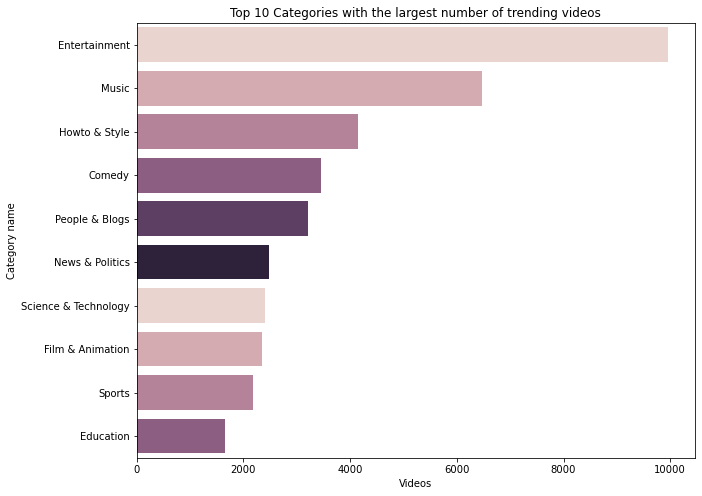

In [269]:
#строим визуализацию
sns.barplot(y=cat_counts['Category name'], 
            x=cat_counts['Videos'], 
            palette=sns.cubehelix_palette())
plt.title("Top 10 Categories with the largest number of trending videos")


Мы видим, что в категории Entertainment наибольшее количество трендовых видео (около 10 000), далее следует категория Music (около 6200), за которой следует категория Howto & Style (около 4100) и т.д.

### Корреляция между параметрами

In [270]:
#находим корреляцию между параметрами
df.corr()

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed
category_id,1.000000,-0.168231,-0.173921,-0.033547,-0.076307,0.048949,-0.013506,-0.030011
views,-0.168231,1.000000,0.849177,0.472213,0.617621,0.002677,0.015355,-0.002256
likes,-0.173921,0.849177,1.000000,0.447186,0.803057,-0.028918,-0.020888,-0.002641
dislikes,-0.033547,0.472213,0.447186,1.000000,0.700184,-0.004431,-0.008230,-0.001853
comment_count,-0.076307,0.617621,0.803057,0.700184,1.000000,-0.028277,-0.013819,-0.003725
comments_disabled,0.048949,0.002677,-0.028918,-0.004431,-0.028277,1.000000,0.319230,-0.002970
ratings_disabled,-0.013506,0.015355,-0.020888,-0.008230,-0.013819,0.319230,1.000000,-0.001526
video_error_or_removed,-0.030011,-0.002256,-0.002641,-0.001853,-0.003725,-0.002970,-0.001526,1.000000


Text(0.5, 1.0, 'Correlation between variables')

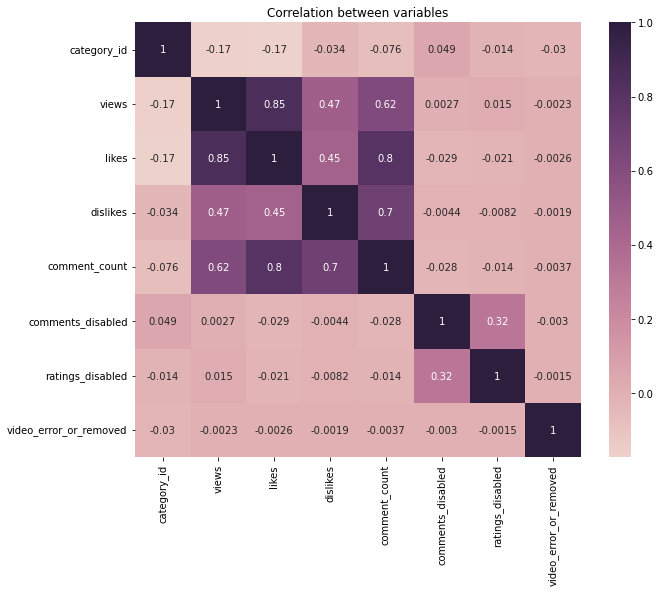

In [271]:
#строим визуализацию
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 10},cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Correlation between variables')

Как видно из таблицы и тепловой карты выше, существует достаточно высокая взаимосвязь между количествами просмотров и лайков (0.85),  лайков и комментариев (0.8) и дизлайков и комментариев (0.7). Также наблюдается некая взаимосвязь между количествами просмотров и комментариев (0.62),  просмотров и дизлайков (0.47) и лайков и дизлайков (0.45).
Для большего понимания, можем построить графики взаимосвязей между наиболее коррелируемые параметрами.

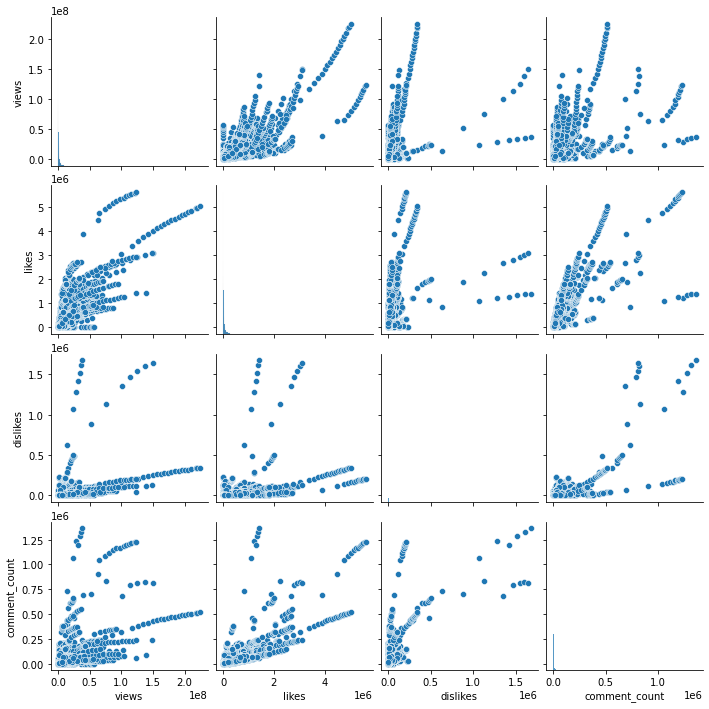

In [272]:
#строим визуализацию
sns.pairplot(df[['views', 'likes', 'dislikes', 'comment_count']])

Графики выше наглядно подтверждают, что параметры действительно в определенной степени положительно коррелируют между собой. По мере увеличения одного, увеличивается и другое (в основном).

### Топ 10 каналов с самым 'поздним' попаданием в тренды

In [296]:
#находим количество дней, прошедших между датой публикации и датой попадания в тренды
#убираем дубликаты, поскольку видео могут быть в тренде несколько дней. оставляем только последние строки (последний день в тренде)

df_trending= df.drop_duplicates(subset='video_id',keep='last',inplace=False)
df_trending['days_to_start_trending'] = [int(x) for x in #переводим количество дней из float в int
                                         (df_trending['trending_date'] - df_trending['publish_time'])
                                         / np.timedelta64(1, 'D')] #вычленяем количество дней из полученного результата


/var/folders/lp/5kjfb8cj4hl70xjvh2_0zl040000gn/T/ipykernel_41834/3036159509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trending['days_to_start_trending'] = [int(x) for x in #переводим количество дней из float в int


In [300]:
#формируем датафрейм с топ 10 видео с самым "поздним" попаданием в тренды
df_trending = df_trending.sort_values(by='days_to_start_trending', ascending=True)[['title','days_to_start_trending']].tail(10)

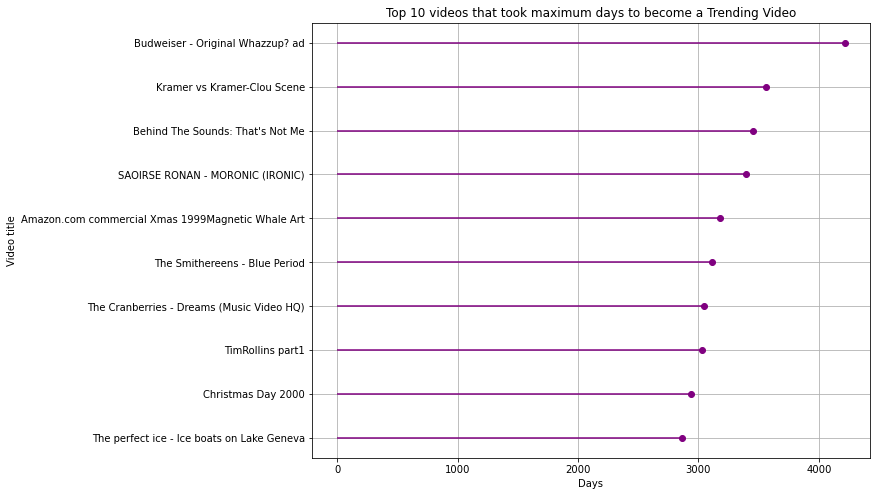

In [301]:
#строим визуализацию
plt.hlines(df_trending['title'], xmin=0, xmax= df_trending['days_to_start_trending'], color = 'purple')
plt.plot(df_trending['days_to_start_trending'], df_trending['title'], "o", color = 'purple')
plt.xlabel('Days')
plt.ylabel('Video title')
plt.title('Top 10 videos that took maximum days to become a Trending Video')
plt.grid()


Как правило, видео попадают в тренды в первые дни после выхода, но есть и такие случаи, когда они набирают популярность спустя длительное время. Как продемонстрировано выше, есть даже видео, которое попало в тренды спустя почти 11(!) лет после публикации. 

### Размах лайков и дизлайков

(0.0, 100000.0)

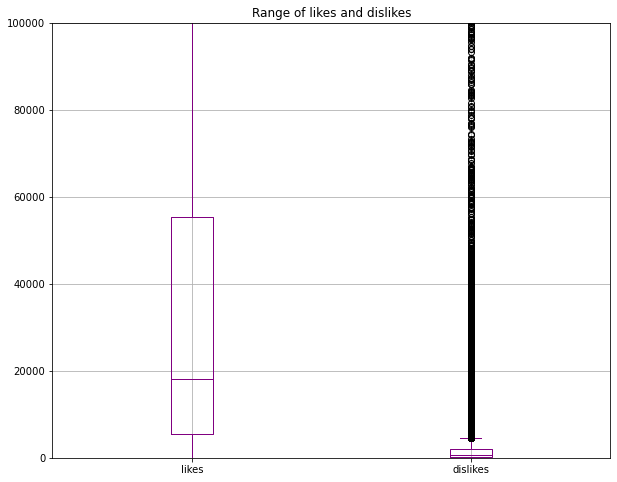

In [276]:
#строим визуализацию
df[["likes","dislikes"]].plot(kind='box',title='Range of likes and dislikes', color ='purple', grid=True)
plt.ylim(0, 100000)

Поскольку выбросов очень много, для наглядности пришлось ограничить диапазон значений до 100 000. Мы видим, что полученные результаты для количества лайков и количества дизлайков сильно отличается. Верхняя граница диаграммы по дизлайкам находится даже ниже первого квартиля по лайкам. Люди ставят лайки гораздо чаще, чем дизлайки.

### Самые популярные слова в заголовках видео

In [277]:
#формируем список из всех встречаемых в заголовках слов
title_words = [i.split() for i in df.title]
title_words = [x.strip(',\|/&()-". ').lower() for y in title_words for x in y]
#выводим на экран 20 самых популярных слов
Counter(title_words).most_common(20)

[('', 24869),
 ('the', 9969),
 ('a', 4782),
 ('to', 4280),
 ('in', 3363),
 ('official', 3296),
 ('of', 3156),
 ('with', 2834),
 ('video', 2384),
 ('on', 2361),
 ('and', 2343),
 ('2018', 2081),
 ('i', 2020),
 ('my', 2010),
 ('trailer', 1983),
 ('how', 1824),
 ('for', 1773),
 ('is', 1700),
 ('you', 1634),
 ('ft', 1301)]

Если игнорировать такие слова, как the, a, to и тд, то можно заметить, что слова 'official', 'video', 'trailer' наиболее часто встречаются в названиях популярных видео. Каждое из них встречается в около 2-3т раз в названиях видео.
Для большей наглядности нарисуем облако слов из 100 самых популярных слов в заголовках видео. Чем более распространено слово, тем больше размер его шрифта.

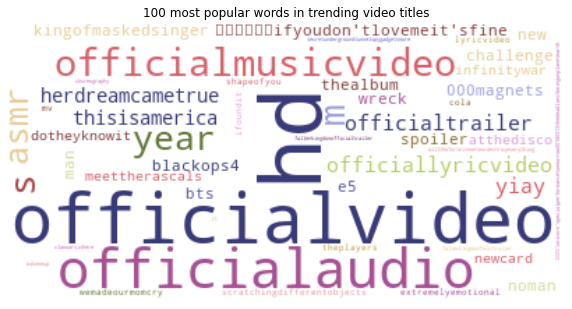

In [278]:
#строим визуализацию
wordcloud = WordCloud(background_color = 'white', colormap="tab20b", collocations=False, 
                      max_words = 100,  max_font_size = 60).generate(''.join(title_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('100 most popular words in trending video titles')
plt.show()